In [1]:
# wget을 활용해서 bert 모델 다운로드 가능
#-*- coding: utf-8 -*-
import os
!wget https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip

if "bert" not in os.listdir():
  os.makedirs("bert")
else:
  pass

import zipfile
import shutil
         
bert_zip = zipfile.ZipFile('multi_cased_L-12_H-768_A-12.zip')
bert_zip.extractall('bert')
 
bert_zip.close()

def copytree(src, dst, symlinks=False, ignore=None):
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, symlinks, ignore)
        else:
            shutil.copy2(s, d)

copytree("bert/multi_cased_L-12_H-768_A-12", "bert")

--2020-02-05 13:29:27--  https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.214.128, 2607:f8b0:400c:c12::80
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.214.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662903077 (632M) [application/zip]
Saving to: ‘multi_cased_L-12_H-768_A-12.zip.1’

multi_cased_L-12_H- 100%[===================>] 632.19M   257MB/s    in 2.5s    

2020-02-05 13:29:30 (257 MB/s) - ‘multi_cased_L-12_H-768_A-12.zip.1’ saved [662903077/662903077]



In [2]:
import tensorflow as tf

import pandas as pd
import numpy as np  
import re
import pickle

import keras as keras
from keras.models import load_model
from keras import backend as K
from keras import Input, Model
from keras import optimizers

from keras import backend as K
from keras.layers import Layer

import codecs
from tqdm import tqdm
import shutil
import json

Using TensorFlow backend.


In [0]:
import warnings
import tensorflow as tf
warnings.filterwarnings(action='ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.logging.set_verbosity(tf.logging.ERROR)

In [4]:
import os
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [5]:
!pip install keras-bert
!pip install keras-radam

In [0]:
from keras_bert import load_trained_model_from_checkpoint, load_vocabulary
from keras_bert import Tokenizer
from keras_bert import AdamWarmup, calc_train_steps

from keras_radam import RAdam

In [7]:
os.listdir('gdrive/My Drive/Colab Notebooks/spam/')
os.listdir('bert')

['vocab.txt',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_config.json',
 'multi_cased_L-12_H-768_A-12',
 'bert_model.ckpt.index',
 'bert_model.ckpt.meta']

In [0]:
path = 'gdrive/My Drive/Colab Notebooks/spam/'

In [0]:
data = pd.read_csv(os.path.join(path, "spam.csv"), encoding='latin1')
data = data.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)

In [0]:
# 스팸이 아니면 0 스팸이면 1
data['v1'] = data['v1'].map(lambda x: 0 if x == "ham" else x)
data['v1'] = data['v1'].map(lambda x: 1 if x == "spam" else x)

In [11]:
data

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [0]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.25, random_state=123)

In [13]:
print(len(train_data),len(test_data),len(train_data)+len(test_data))
train_data

4179 1393 5572


,v1,v2
647,1,PRIVATE! Your 2003 Account Statement for shows...
3843,0,"Yeah that's what I thought, lemme know if anyt..."
3044,0,"Hello, yeah i've just got out of the bath and ..."
2536,0,You do what all you like
4644,0,Are you planning to come chennai?
...,...,...
5218,0,I accidentally brought em home in the box
4060,0,"Aight I've been set free, think you could text..."
1346,0,Is it ok if I stay the night here? Xavier has ...
3454,0,No need lar. Jus testing e phone card. Dunno n...


In [0]:
SEQ_LEN = 128
BATCH_SIZE = 16
EPOCHS=2
LR=1e-5

pretrained_path ="bert"
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

In [0]:
token_dict = {}
with codecs.open(vocab_path, 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip()
        if "_" in token:
          token = token.replace("_","")
          token = "##" + token
        token_dict[token] = len(token_dict)

In [0]:
tokenizer = Tokenizer(token_dict)

In [17]:
print(tokenizer.tokenize("keras is reall fun."), tokenizer.tokenize("we can manipulate AI."))

['[CLS]', 'keras', 'is', 'real', '##l', 'fun', '.', '[SEP]'] ['[CLS]', 'we', 'can', 'mani', '##pul', '##ate', 'ai', '.', '[SEP]']


In [0]:
def convert_data(data_df):
    global tokenizer
    indices, targets = [], []
    for i in data_df.index:
        ids, segments = tokenizer.encode(data_df['v2'][i], max_len=SEQ_LEN)
        indices.append(ids)
        targets.append(data_df['v1'][i])
    items = list(zip(indices, targets))
    
    indices, targets = zip(*items)
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)], np.array(targets)

def load_data(pandas_dataframe):
    data_df = pandas_dataframe
    
    
    data_df['v2'] = data_df['v2'].astype(str)



    data_x, data_y = convert_data(data_df)

    return data_x, data_y

In [0]:
train_x, train_y = load_data(train_data)
test_x, test_y = load_data(test_data)

In [20]:
print(train_x,train_y)

[array([[  101, 14591,   106, ...,     0,     0,     0],
       [  101, 11023, 12257, ...,     0,     0,     0],
       [  101, 61694, 10133, ...,     0,     0,     0],
       ...,
       [  101, 10124, 10271, ...,     0,     0,     0],
       [  101, 10192, 17367, ...,     0,     0,     0],
       [  101,   177, 14541, ...,     0,     0,     0]]), array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])] [1 0 0 ... 0 0 0]


In [0]:
layer_num = 12
model = load_trained_model_from_checkpoint( #bert.5h인가 불러오기
    config_path,
    checkpoint_path,
    training=True,
    trainable=True,
    seq_len=SEQ_LEN,)

In [22]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, 128)          0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, 128)          0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 128, 768), ( 91812096    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 128, 768)     1536        Input-Segment[0][0]              
____________________________________________________________________________________________

In [0]:
def get_bert_finetuning_model(model):
  inputs = model.inputs[:2]
  dense = model.layers[-3].output


  outputs = keras.layers.Dense(1, activation='sigmoid',kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02),
                              name = 'real_output')(dense)



  bert_model = keras.models.Model(inputs, outputs)
  bert_model.compile(
      optimizer=RAdam(learning_rate=0.00001, weight_decay=0.0025),
      loss='binary_crossentropy',
      metrics=['accuracy'])
  
  return bert_model

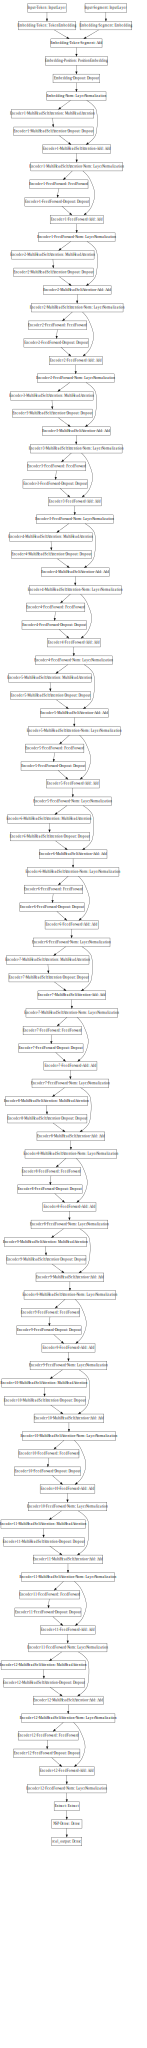

In [24]:
from IPython.display import SVG
from keras.utils import model_to_dot


SVG(model_to_dot(get_bert_finetuning_model(model), dpi=65).create(prog='dot', format='svg'))


In [25]:
sess = K.get_session()
uninitialized_variables = set([i.decode('ascii') for i in sess.run(tf.report_uninitialized_variables())])
init = tf.variables_initializer([v for v in tf.global_variables() if v.name.split(':')[0] in uninitialized_variables])
sess.run(init)

bert_model = get_bert_finetuning_model(model)
history = bert_model.fit(train_x, train_y, epochs=2, batch_size=16, verbose = 1, validation_data=(test_x, test_y), shuffle=True)

Train on 4179 samples, validate on 1393 samples
Epoch 1/2
4179/4179 [==============================] - 177s 42ms/step - loss: 0.2670 - acc: 0.9139 - val_loss: 0.0624 - val_acc: 0.9864
Epoch 2/2
4179/4179 [==============================] - 162s 39ms/step - loss: 0.0528 - acc: 0.9885 - val_loss: 0.0362 - val_acc: 0.9907


In [0]:
def sentence_convert_data(data):
    global tokenizer
    indices = []
    ids, segments = tokenizer.encode(data, max_len=SEQ_LEN)
    indices.append(ids)
        
    items = indices
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)]

def spam_evaluation_predict(sentence):
    data_x = sentence_convert_data(sentence)
    predict = bert_model.predict(data_x)
    predict_answer = np.round(np.ravel(predict), 0).item()
    
    if predict_answer == 0:
      print("정상적인 메세지입니다!!.")
    elif predict_answer == 1:
      print("스팸메일 입니다!!")

In [35]:
spam_evaluation_predict("obbba mo he??")

정상적인 메세지입니다!!.


In [41]:
spam_evaluation_predict("you have to pay 10000$ ")
# 10000$ 까지는 봐준다 이건가??

정상적인 메세지입니다!!.


In [39]:
spam_evaluation_predict("you have to pay 100000$")

스팸메일 입니다!!
